In [1]:
!pip3 install tensorflow_hub

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import numpy as np
from collections import namedtuple
print("TensorFlow Version:",tf.__version__)
print("Hub version: ",hub.__version__)

TensorFlow Version: 2.2.0
Hub version:  0.9.0


In [3]:
bert_layer=hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",trainable=True)

In [4]:
MAX_SEQ_LEN=70
input_word_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(MAX_SEQ_LEN,), dtype=tf.int32,
                                    name="segment_ids")

In [5]:
def get_masks(tokens, max_seq_length):
    return [1]*len(tokens) + [0] * (max_seq_length - len(tokens))
 
def get_segments(tokens, max_seq_length):
    """Segments: 0 for the first sequence, 1 for the second"""
    segments = []
    current_segment_id = 0
    for token in tokens:
        segments.append(current_segment_id)
        if token == "[SEP]":
            current_segment_id = 1
    return segments + [0] * (max_seq_length - len(tokens))

In [6]:
pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])

In [7]:
FullTokenizer= bert.bert_tokenization.FullTokenizer

vocab_file=bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case=bert_layer.resolved_object.do_lower_case.numpy()

tokenizer=FullTokenizer(vocab_file,do_lower_case)

def get_ids(tokens, tokenizer, max_seq_length):
    """Token ids from Tokenizer vocab"""
    token_ids = tokenizer.convert_tokens_to_ids(tokens,)
    input_ids = token_ids + [0] * (max_seq_length-len(token_ids))
    return input_ids

In [8]:
def create_single_input(sentence,MAX_LEN):
  
  stokens = tokenizer.tokenize(sentence)
  
  stokens = stokens[:MAX_LEN]
  
  stokens = ["[CLS]"] + stokens + ["[SEP]"]
 
  ids = get_ids(stokens, tokenizer, MAX_SEQ_LEN)
  masks = get_masks(stokens, MAX_SEQ_LEN)
  segments = get_segments(stokens, MAX_SEQ_LEN)
 
  return ids,masks,segments
 
def create_input_array(sentences):
 
  input_ids, input_masks, input_segments = [], [], []
 
  for sentence in tqdm(sentences,position=0, leave=True):
  
    ids,masks,segments=create_single_input(sentence,MAX_SEQ_LEN-2)
 
    input_ids.append(ids)
    input_masks.append(masks)
    input_segments.append(segments)
 
  return [np.asarray(input_ids, dtype=np.int32), 
            np.asarray(input_masks, dtype=np.int32), 
            np.asarray(input_segments, dtype=np.int32)]

In [9]:
print("Vocab size:", len(tokenizer.vocab))

Vocab size: 30522


In [27]:
#x = tf.keras.layers.GlobalAveragePooling1D()(sequence_output)
#x = tf.keras.layers.Dropout(0.2)(x)
#out = tf.keras.layers.Dense(1, activation="sigmoid", name="dense_output")(x)
 
#model = tf.keras.models.Model(
#      inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
 
#model.compile(loss='binary_crossentropy',
#                  optimizer='adam',
#                  metrics=['accuracy'])

In [28]:
#model.summary()

In [12]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
df = pd.read_json('/home/jovyan/data/train.jsonl', lines=True)
df_dev = pd.read_json('/home/jovyan/data/dev.jsonl', lines=True)
df_test_f = pd.read_json('/home/jovyan/data/test.jsonl', lines=True)
df = df[["label","text"]]
df_dev = df_dev[["label","text"]]
#df = pd.concat([df, df_dev], ignore_index=True)
df[df.label == 1].head(2)

,label,text
10,1,jew mad? get fuhrerious!
12,1,brother... a day without a blast is a day wasted


In [13]:
x_train = df["text"]
y_train = df["label"]

x_test = df_dev["text"]
y_test = df_dev["label"]

In [14]:
df.count()
print(x_train.count(), x_test.count())

8500 500


In [15]:
inputs=create_input_array(x_train)

100%|██████████| 8500/8500 [00:02<00:00, 3886.91it/s]


In [24]:
len(tokenizer.vocab)

30522

In [25]:
from keras.layers import Embedding,Dense,GlobalMaxPool1D,Dropout,Flatten,Bidirectional,LSTM
from keras.models import Sequential
embedding_dim=50
model=Sequential([Embedding(input_dim=len(tokenizer.vocab),output_dim=embedding_dim,input_length=MAX_SEQ_LEN),
                 Bidirectional(LSTM(32,return_sequences=True)),
                 GlobalMaxPool1D(),
                 Dense(32,activation='relu'),
                 Dropout(0.5),
                 Dense(1,activation='sigmoid')
                 ])

model.compile(optimizer='adam',loss='binary_crossentropy',metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 50)            1526100   
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 64)            21248     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,549,461
Trainable params: 1,549,461
Non-trainable params: 0
______________________________________________

In [39]:
history = model.fit(inputs[0], y_train, epochs=1, batch_size=15, validation_split=.25, steps_per_epoch=1000)

 425/1000 [===========>..................] - ETA: 33s - loss: 0.2170 - accuracy: 0.8690WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 1000 batches). You may need to use the repeat() function when building your dataset.


 425/1000 [===========>..................] - 27s 63ms/step - loss: 0.2170 - accuracy: 0.8690 - val_loss: 2.0609 - val_accuracy: 0.6005


In [40]:
history.history

{'loss': [0.21700319647789001],
 'accuracy': [0.869019627571106],
 'val_loss': [2.060885190963745],
 'val_accuracy': [0.6004706025123596]}

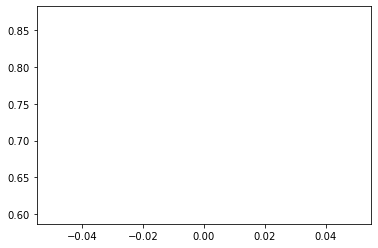

In [41]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [ ]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("bert2_h5_model.h5")

# It can be used to reconstruct the model identically.
# model = keras.models.load_model("bert_h5_model.h5")

In [42]:
test_inputs=create_input_array(x_test)
y_pred = model.predict(test_inputs[0]).ravel()

100%|██████████| 500/500 [00:00<00:00, 4077.33it/s]


In [43]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

0.502488


In [83]:
# final test data
xtest_f = df_test_f["text"]
xtestf= create_input_array(xtest_f)

y_test_f_pred = model.predict(xtestf[0]).ravel()

100%|██████████| 1000/1000 [00:00<00:00, 3006.82it/s]


In [85]:
from datetime import datetime
df_to_submit = df_test_f[["id"]]
df_to_submit["proba"] = y_test_f_pred
df_to_submit["label"] = df_to_submit['proba'].map(lambda x: 1 if x > 0.5 else 0)
df_to_submit.head()

#print(df_test_f[df_test_f.label == 1])
df_to_submit.to_csv('/home/jovyan/data/csv_to_submit' + datetime.now().strftime("%Y%m%d-%H%M%S") +'.csv', index = False)


<ipython-input-85-73dce8b73542>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_to_submit["proba"] = y_test_f_pred
